In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re
import nltk
from nltk.stem.porter import *
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn_pandas import DataFrameMapper, cross_val_score

## Reading and exploring tweets

In [4]:
tweets_df = pd.read_csv("Tweets.csv")

In [5]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 8 columns):
tweet_id             14640 non-null float64
airline_sentiment    14640 non-null object
name                 14640 non-null object
text                 14640 non-null object
tweet_coord          1019 non-null object
tweet_created        14640 non-null object
tweet_location       9907 non-null object
user_timezone        9820 non-null object
dtypes: float64(1), object(7)
memory usage: 915.1+ KB


In [6]:
tweets_df.describe(include='all')

,tweet_id,airline_sentiment,name,text,tweet_coord,tweet_created,tweet_location,user_timezone
count,1.464000e+04,14640,14640,14640,1019,14640,9907,9820
unique,NaN,3,7701,14427,832,6804,3081,85
top,NaN,negative,JetBlueNews,@united thanks,"[0.0, 0.0]",2/23/2015 11:50,"Boston, MA",Eastern Time (US & Canada)
freq,NaN,9178,63,6,164,11,157,3744
mean,5.692184e+17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,7.791092e+14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,5.675880e+17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,5.685590e+17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,5.694780e+17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,5.698902e+17,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
tweets_df.tail()

,tweet_id,airline_sentiment,name,text,tweet_coord,tweet_created,tweet_location,user_timezone
14635,5.695880e+17,positive,KristenReenders,@AmericanAir thank you we got on a different f...,NaN,2/22/2015 12:01,NaN,NaN
14636,5.695870e+17,negative,itsropes,@AmericanAir leaving over 20 minutes Late Flig...,NaN,2/22/2015 11:59,Texas,NaN
14637,5.695870e+17,neutral,sanyabun,@AmericanAir Please bring American Airlines to...,NaN,2/22/2015 11:59,"Nigeria,lagos",NaN
14638,5.695870e+17,negative,SraJackson,"@AmericanAir you have my money, you change my ...",NaN,2/22/2015 11:59,New Jersey,Eastern Time (US & Canada)
14639,5.695870e+17,neutral,daviddtwu,@AmericanAir we have 8 ppl so we need 2 know h...,NaN,2/22/2015 11:58,"dallas, TX",NaN


### Exploring categorical data

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64


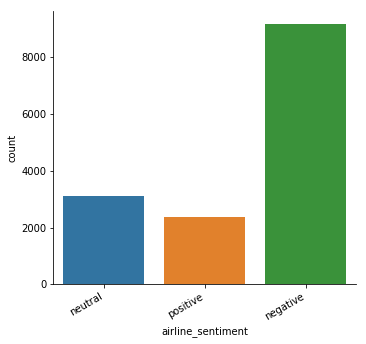

In [8]:
print (tweets_df['airline_sentiment'].value_counts())
ax = sns.catplot(x='airline_sentiment',kind='count',data=tweets_df)
ax.fig.autofmt_xdate()

In [9]:
tweets_df['tweet_location'].value_counts()[:10]

Boston, MA           157
New York, NY         156
Washington, DC       150
New York             127
USA                  126
Chicago              104
Los Angeles, CA       96
New York City         96
NYC                   95
San Francisco, CA     91
Name: tweet_location, dtype: int64

In [10]:
tweets_df['user_timezone'].value_counts()[:10]

Eastern Time (US & Canada)     3744
Central Time (US & Canada)     1931
Pacific Time (US & Canada)     1208
Quito                           738
Atlantic Time (Canada)          497
Mountain Time (US & Canada)     369
Arizona                         229
London                          195
Alaska                          108
Sydney                          107
Name: user_timezone, dtype: int64

In [11]:
tweets_df['name'].value_counts()[:10]

JetBlueNews        63
kbosspotter        32
_mhertz            29
otisday            28
throthra           27
weezerandburnie    23
rossj987           23
GREATNESSEOA       22
MeeestarCoke       22
scoobydoo9749      21
Name: name, dtype: int64

## Tweets pre-processing

### Remove duplicates

In [12]:
tweets_df.shape

(14640, 8)

In [13]:
tweets_df.sort_values("text", inplace=True)
tweets_df.drop_duplicates(keep=False,inplace=True)

In [14]:
tweets_df.shape

(14366, 8)

### Handling nulls values

In [15]:
# find nan values
print(tweets_df[~tweets_df.name.notnull()].shape)
print(tweets_df[~tweets_df.text.notnull()].shape)
print(tweets_df[~tweets_df.tweet_location.notnull()].shape)
print(tweets_df[~tweets_df.user_timezone.notnull()].shape)

(0, 8)
(0, 8)
(4649, 8)
(4740, 8)


In [16]:
tweets_df.shape

(14366, 8)

In [17]:
tweets_df.tweet_location = tweets_df.tweet_location.fillna('None')
tweets_df.user_timezone = tweets_df.user_timezone.fillna('None')

#columns = ['text', 'name', 'tweet_location', 'user_timezone']
#tweets_df = tweets_df.dropna(subset=columns)

In [18]:
print(tweets_df[~tweets_df.tweet_location.notnull()].shape)
print(tweets_df[~tweets_df.user_timezone.notnull()].shape)
print(tweets_df.shape)

(0, 8)
(0, 8)
(14366, 8)


In [19]:
tweets_df[tweets_df.tweet_location=='None'].head(1)

,tweet_id,airline_sentiment,name,text,tweet_coord,tweet_created,tweet_location,user_timezone
4978,5.695870e+17,negative,danihampton,&lt;3 &lt;3 RT @SouthwestAir! @danihampton Sor...,NaN,2/22/2015 11:58,None,Arizona


### Removing Twitter Handles (@user) 

In [20]:
tweets_df['tidy_tweet'] = tweets_df['text'].replace(r'@[\w]*', '', regex=True)
tweets_df.head()

,tweet_id,airline_sentiment,name,text,tweet_coord,tweet_created,tweet_location,user_timezone,tidy_tweet
7064,5.699430e+17,positive,SeanUppercut,"""LOL you guys are so on it"" - me, had this bee...",NaN,2/23/2015 11:31,"Detroit, MI",Quito,"""LOL you guys are so on it"" - me, had this bee..."
7008,5.699590e+17,neutral,UAKShine,#Real RT @JetBlue: Our fleet's on fleek. http:...,NaN,2/23/2015 12:34,Bushmansted,Quito,#Real RT : Our fleet's on fleek. http://t.co/E...
14272,5.696430e+17,negative,sarrraright,#nothelpful MT @AmericanAir: Our call volume i...,NaN,2/22/2015 15:42,Cathedral Heights,Eastern Time (US & Canada),#nothelpful MT : Our call volume is extremely ...
4978,5.695870e+17,negative,danihampton,&lt;3 &lt;3 RT @SouthwestAir! @danihampton Sor...,NaN,2/22/2015 11:58,None,Arizona,&lt;3 &lt;3 RT ! Sorry to hear about the WiFi...
7092,5.699380e+17,neutral,MelechT,*On the brink of bankruptcy. “@JetBlue: Our fl...,NaN,2/23/2015 11:14,DMV,Central Time (US & Canada),*On the brink of bankruptcy. “: Our fleet's on...


### Removing Punctuations, Numbers, and Special Characters

In [21]:
tweets_df['tidy_tweet'] = tweets_df['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")

In [22]:
tweets_df.head()

,tweet_id,airline_sentiment,name,text,tweet_coord,tweet_created,tweet_location,user_timezone,tidy_tweet
7064,5.699430e+17,positive,SeanUppercut,"""LOL you guys are so on it"" - me, had this bee...",NaN,2/23/2015 11:31,"Detroit, MI",Quito,LOL you guys are so on it me had this bee...
7008,5.699590e+17,neutral,UAKShine,#Real RT @JetBlue: Our fleet's on fleek. http:...,NaN,2/23/2015 12:34,Bushmansted,Quito,#Real RT Our fleet s on fleek http t co E...
14272,5.696430e+17,negative,sarrraright,#nothelpful MT @AmericanAir: Our call volume i...,NaN,2/22/2015 15:42,Cathedral Heights,Eastern Time (US & Canada),#nothelpful MT Our call volume is extremely ...
4978,5.695870e+17,negative,danihampton,&lt;3 &lt;3 RT @SouthwestAir! @danihampton Sor...,NaN,2/22/2015 11:58,None,Arizona,lt lt RT Sorry to hear about the WiFi...
7092,5.699380e+17,neutral,MelechT,*On the brink of bankruptcy. “@JetBlue: Our fl...,NaN,2/23/2015 11:14,DMV,Central Time (US & Canada),On the brink of bankruptcy Our fleet s on...


### Removing Short Words

In [23]:
tweets_df['tidy_tweet'] = tweets_df['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

In [24]:
tweets_df.head()

,tweet_id,airline_sentiment,name,text,tweet_coord,tweet_created,tweet_location,user_timezone,tidy_tweet
7064,5.699430e+17,positive,SeanUppercut,"""LOL you guys are so on it"" - me, had this bee...",NaN,2/23/2015 11:31,"Detroit, MI",Quito,guys this been months fleet fleek http LYcARlTFHl
7008,5.699590e+17,neutral,UAKShine,#Real RT @JetBlue: Our fleet's on fleek. http:...,NaN,2/23/2015 12:34,Bushmansted,Quito,#Real fleet fleek http ERzht
14272,5.696430e+17,negative,sarrraright,#nothelpful MT @AmericanAir: Our call volume i...,NaN,2/22/2015 15:42,Cathedral Heights,Eastern Time (US & Canada),#nothelpful call volume extremely high today a...
4978,5.695870e+17,negative,danihampton,&lt;3 &lt;3 RT @SouthwestAir! @danihampton Sor...,NaN,2/22/2015 11:58,None,Arizona,Sorry hear about WiFi connection Dani Please y...
7092,5.699380e+17,neutral,MelechT,*On the brink of bankruptcy. “@JetBlue: Our fl...,NaN,2/23/2015 11:14,DMV,Central Time (US & Canada),brink bankruptcy fleet fleek http ldxn


### Tokenization

In [25]:
tokenized_tweets = tweets_df['tidy_tweet'].apply(lambda x: x.split())

In [26]:
tokenized_tweets.head()

7064     [guys, this, been, months, fleet, fleek, http,...
7008                    [#Real, fleet, fleek, http, ERzht]
14272    [#nothelpful, call, volume, extremely, high, t...
4978     [Sorry, hear, about, WiFi, connection, Dani, P...
7092         [brink, bankruptcy, fleet, fleek, http, ldxn]
Name: tidy_tweet, dtype: object

### Stemming 

In [27]:
stemmer = PorterStemmer()

tokenized_tweets = tokenized_tweets.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweets.head()

7064     [guy, thi, been, month, fleet, fleek, http, ly...
7008                    [#real, fleet, fleek, http, erzht]
14272    [#nothelp, call, volum, extrem, high, today, a...
4978     [sorri, hear, about, wifi, connect, dani, plea...
7092         [brink, bankruptci, fleet, fleek, http, ldxn]
Name: tidy_tweet, dtype: object

In [28]:
# Aggregate tokens together again

tokenized_tweets = [' '.join(token) for token in tokenized_tweets]

In [29]:
tweets_df['tidy_tweet'] = tokenized_tweets

In [30]:
tweets_df.head()

,tweet_id,airline_sentiment,name,text,tweet_coord,tweet_created,tweet_location,user_timezone,tidy_tweet
7064,5.699430e+17,positive,SeanUppercut,"""LOL you guys are so on it"" - me, had this bee...",NaN,2/23/2015 11:31,"Detroit, MI",Quito,guy thi been month fleet fleek http lycarltfhl
7008,5.699590e+17,neutral,UAKShine,#Real RT @JetBlue: Our fleet's on fleek. http:...,NaN,2/23/2015 12:34,Bushmansted,Quito,#real fleet fleek http erzht
14272,5.696430e+17,negative,sarrraright,#nothelpful MT @AmericanAir: Our call volume i...,NaN,2/22/2015 15:42,Cathedral Heights,Eastern Time (US & Canada),#nothelp call volum extrem high today apolog p...
4978,5.695870e+17,negative,danihampton,&lt;3 &lt;3 RT @SouthwestAir! @danihampton Sor...,NaN,2/22/2015 11:58,None,Arizona,sorri hear about wifi connect dani pleas your ...
7092,5.699380e+17,neutral,MelechT,*On the brink of bankruptcy. “@JetBlue: Our fl...,NaN,2/23/2015 11:14,DMV,Central Time (US & Canada),brink bankruptci fleet fleek http ldxn


## Exploring Tweets

## what are the common words? 

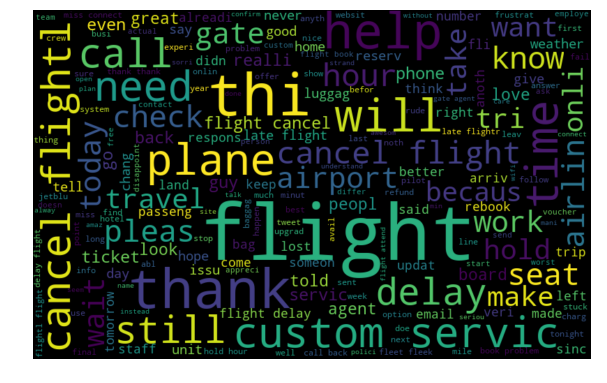

In [31]:
# All Common words 
all_words = ' '.join([text for text in tweets_df['tidy_tweet']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

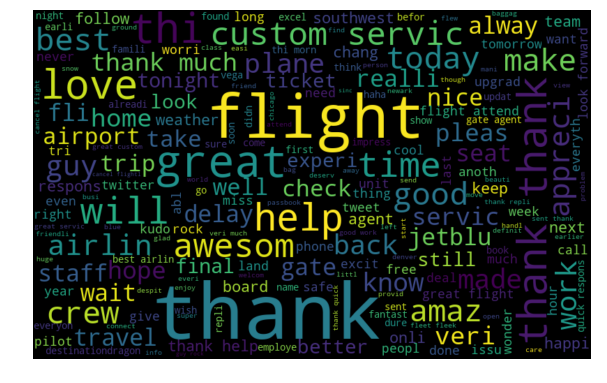

In [32]:
# All Positive words 
all_words = ' '.join([text for text in tweets_df['tidy_tweet'][tweets_df['airline_sentiment'] == 'positive']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

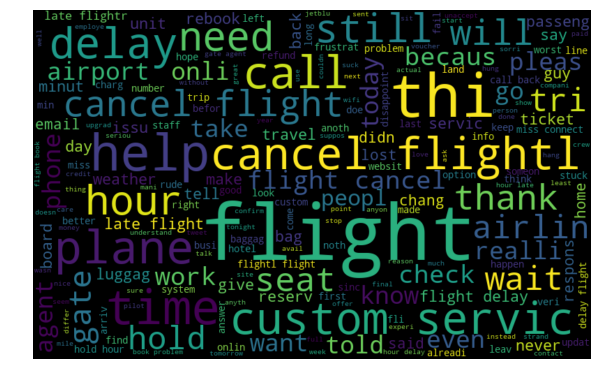

In [33]:
# All Negative words 
all_words = ' '.join([text for text in tweets_df['tidy_tweet'][tweets_df['airline_sentiment'] == 'negative']])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Create test set

In [34]:
train_set, test_set = train_test_split(tweets_df, test_size=0.2, random_state=42)

In [35]:
len(train_set)

11492

In [36]:
len(test_set)

2874

## Feature engineering

In [37]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 3), stop_words='english')
features = tfidf.fit_transform(tweets_df['tidy_tweet']).toarray()
labels = tweets_df['airline_sentiment']
features.shape

(14366, 3665)

## Building the model

### Vectorization

In [38]:
mapper = DataFrameMapper([
     ('tidy_tweet', TfidfVectorizer(norm='l2', ngram_range=(1, 1), stop_words='english')),
     ('name', TfidfVectorizer()),
     ('tweet_location', TfidfVectorizer()),
     ('user_timezone', TfidfVectorizer()),
 ])

features = mapper.fit_transform(train_set)

### Create Evaluation set

In [39]:
categories = train_set.airline_sentiment

x, x_eval, y, y_eval = train_test_split(features,categories,test_size=0.2,train_size=0.8, random_state = 0)

In [40]:
# Check Accuracy
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 


def print_accuracy():
    y_pred = clf.predict(x_eval)

    from sklearn.metrics import confusion_matrix
    conf_mat = confusion_matrix(y_eval, y_pred)

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d',
                xticklabels=tweets_df.airline_sentiment.unique(), 
                yticklabels=tweets_df.airline_sentiment.unique())
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    print('Accuracy Score :',accuracy_score(y_eval, y_pred))
    print('')
    print(classification_report(y_eval, y_pred, target_names=tweets_df.airline_sentiment.unique()))

### RandomForest

/Users/samehamin/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


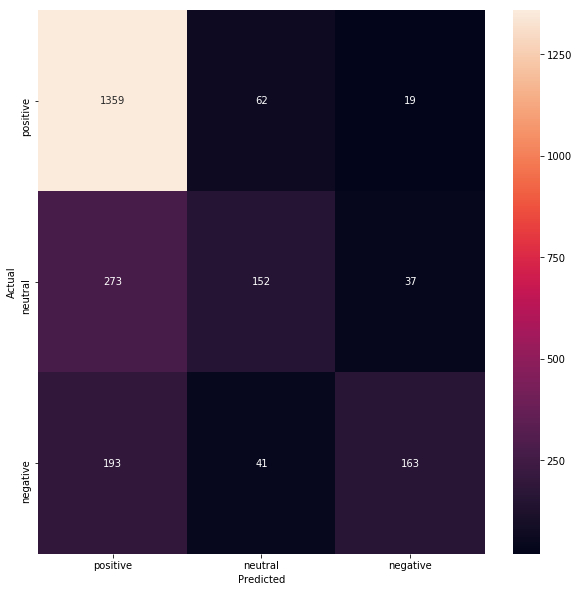

Accuracy Score : 0.7281426707264028

              precision    recall  f1-score   support

    positive       0.74      0.94      0.83      1440
     neutral       0.60      0.33      0.42       462
    negative       0.74      0.41      0.53       397

   micro avg       0.73      0.73      0.73      2299
   macro avg       0.70      0.56      0.60      2299
weighted avg       0.71      0.73      0.70      2299



In [41]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=0)
clf.fit(x, y)
print_accuracy()

### Naiive Bayes

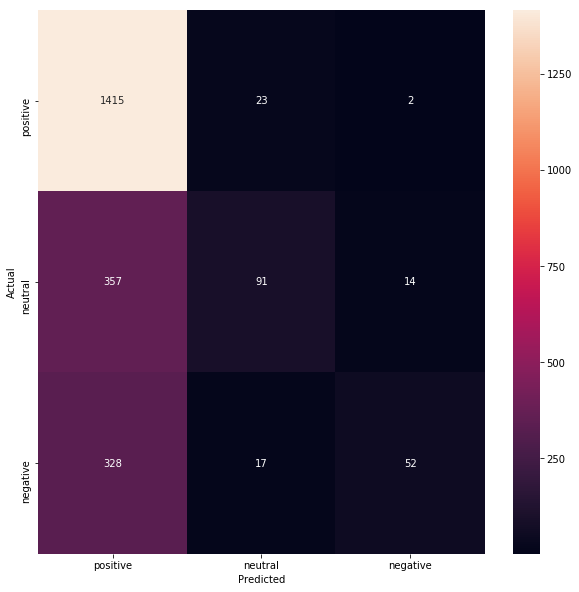

Accuracy Score : 0.6776859504132231

              precision    recall  f1-score   support

    positive       0.67      0.98      0.80      1440
     neutral       0.69      0.20      0.31       462
    negative       0.76      0.13      0.22       397

   micro avg       0.68      0.68      0.68      2299
   macro avg       0.71      0.44      0.44      2299
weighted avg       0.69      0.68      0.60      2299



In [42]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(x, y)
print_accuracy()

### Logistic Regression

/Users/samehamin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/samehamin/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


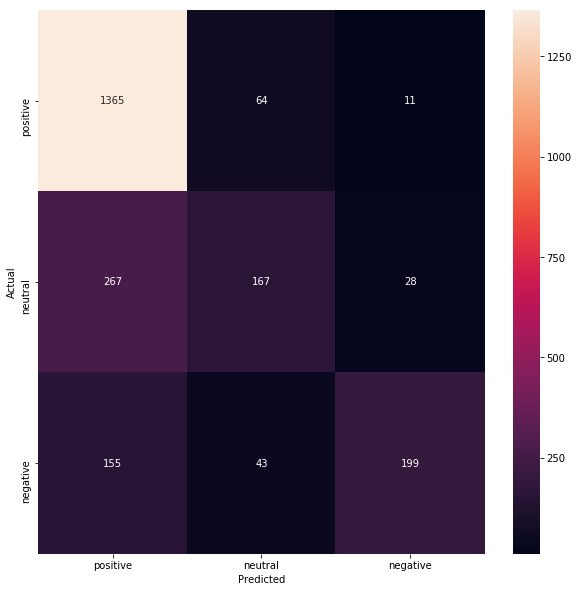

Accuracy Score : 0.7529360591561548

              precision    recall  f1-score   support

    positive       0.76      0.95      0.85      1440
     neutral       0.61      0.36      0.45       462
    negative       0.84      0.50      0.63       397

   micro avg       0.75      0.75      0.75      2299
   macro avg       0.74      0.60      0.64      2299
weighted avg       0.75      0.75      0.73      2299



In [43]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0).fit(x, y)
print_accuracy()

### SVM

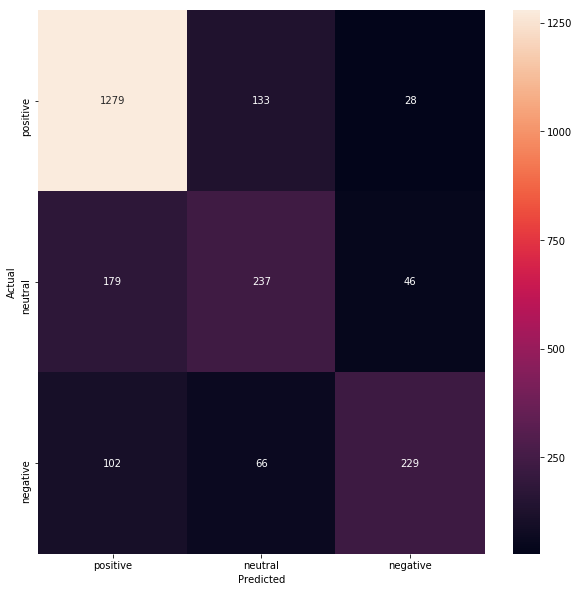

Accuracy Score : 0.7590256633318835

              precision    recall  f1-score   support

    positive       0.82      0.89      0.85      1440
     neutral       0.54      0.51      0.53       462
    negative       0.76      0.58      0.65       397

   micro avg       0.76      0.76      0.76      2299
   macro avg       0.71      0.66      0.68      2299
weighted avg       0.75      0.76      0.75      2299



In [44]:
from sklearn.svm import LinearSVC
clf = LinearSVC().fit(x, y)
print_accuracy()